# Imports

In [1]:
## imports 
import pandas as pd
import numpy as np
import yaml
import plotnine
from plotnine import *

import bitdotio

## print mult
## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## function to feed path name to load
## credentials
def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)


# 0. Preliminary: define connection and read sample of data

Task: 

- Connect to the database - instructions here and API key on Canvas: https://github.com/rebeccajohnson88/PPOL564_slides_activities/issues/65
- Read a sample of data (first five rows) from the `caseinit` table in the database

In [2]:
creds = load_creds("../../../cred.yml")
b = bitdotio.bitdotio(creds['class_database']['api_key'])
cnx = b.get_connection("rebeccajohnson88/ppol564_classdb")

In [3]:
## define a query to pull first 5 rows
## from caseinit table
sample_case_q = """ select * 
from caseinit 
limit 5
"""

In [4]:
## feed read sql query the query
## and my database connection
read_sample_d = pd.read_sql_query(sample_case_q, cnx)
print(type(read_sample_d))
read_sample_d

<class 'pandas.core.frame.DataFrame'>


,case_id,case_participant_id,offense_category,updated_offense_category,race,gender,age_at_incident,is_in_diversion
0,588837642829,442420671352,Sex Crimes,Human Trafficking,Black,Male,26,False
1,580726027874,432312003079,Narcotics,Narcotics,White [Hispanic or Latino],Male,27,True
2,508318872311,350031230404,UUW - Unlawful Use of Weapon,UUW - Unlawful Use of Weapon,Black,Male,29,True
3,565190677205,414462877324,Armed Robbery,Armed Robbery,Black,Male,31,False
4,570518536922,420717727182,DUI,Aggravated DUI,White [Hispanic or Latino],Male,41,True


# 1. Row and column filtering

## 1.1 Pulling columns

*Task*: pull the `CASE_ID` and `CASE_PARTICIPANT_ID` columns from the `caseinit` table

In [5]:
## select specific columns
pull_id_q = """
select CASE_ID, CASE_PARTICIPANT_ID
from caseinit
"""

id_d = pd.read_sql_query(pull_id_q,
                             cnx)
id_d.head()

,case_id,case_participant_id
0,588837642829,442420671352
1,580726027874,432312003079
2,508318872311,350031230404
3,565190677205,414462877324
4,570518536922,420717727182


## 1.2 Subsetting rows



### 1.2.1 Subsetting rows based on logical conditions

*Task*: pull those two columns and restrict to rows where `AGE_AT_INCIDENT` is older than 40

In [6]:
## select specific rows using where
pull_id_age_q = """
select CASE_ID, CASE_PARTICIPANT_ID, 
AGE_AT_INCIDENT
from caseinit
where AGE_AT_INCIDENT > 40
"""

id_age = pd.read_sql_query(pull_id_age_q,
                cnx)
id_age.head()

,case_id,case_participant_id,age_at_incident
0,570518536922,420717727182,41
1,527994704470,370968036249,54
2,577322559858,428321547353,41
3,563654115781,412641908194,54
4,567466970992,417158371404,42


*Task*: pull those two columns and restrict to rows where `RACE` is Black or HISPANIC 

In [7]:
## select specific rows using IN
pull_id_r_q = """
select CASE_ID, CASE_PARTICIPANT_ID, 
RACE
from caseinit
where RACE in ('Black', 'HISPANIC')
"""

id_r = pd.read_sql_query(pull_id_r_q,
                cnx)
id_r.race.value_counts()



Black       38493
HISPANIC      787
Name: race, dtype: int64

### 1.2.2 Subsetting rows based on similarity to a string

*Task*: use the `like` command to subset to rows with Black anywhere in the `RACE` column

In [8]:
## select specific rows using similarity
pull_id_r_q_2 = """
select CASE_ID, CASE_PARTICIPANT_ID, 
RACE
from caseinit
where RACE like '%Black%'
"""

id_r = pd.read_sql_query(pull_id_r_q_2,
                cnx)
id_r.race.value_counts()

Black                               38493
White/Black [Hispanic or Latino]      308
Name: race, dtype: int64

## 1.3 Creating new columns

*Task*: create a new column-- `charge_update`-- that takes the value "Same offense" if offense category is the same as updated offense category; "diff offense" otherwise

In [9]:
## create new col 
## using case when logic
compare_charge_q = """
select *,
CASE 
    WHEN OFFENSE_CATEGORY = UPDATED_OFFENSE_CATEGORY THEN 'Same offense'
    ELSE 'Diff offense'
END as charge_update
from caseinit
"""

compare_charge_d = pd.read_sql_query(compare_charge_q, cnx)

compare_charge_d.charge_update.value_counts()
samp = compare_charge_d.groupby('charge_update').sample(n = 2, random_state = 919)
samp[['offense_category', 'updated_offense_category', 'charge_update']]

Same offense    54589
Diff offense     7467
Name: charge_update, dtype: int64

,offense_category,updated_offense_category,charge_update
17006,DUI,Aggravated DUI,Diff offense
58055,Driving With Suspended Or Revoked License,Aggravated DUI,Diff offense
7513,Narcotics,Narcotics,Same offense
54366,Narcotics,Narcotics,Same offense


### 1.3.1 Code that deliberately throws error due to creating a new column in same step as row filter

In [10]:
## create new col 
## using case when logic
## and then row filter
## throws error bc doesn't
## know that charge_update exists
compare_charge_filt_q = """
select *,
CASE 
WHEN OFFENSE_CATEGORY = UPDATED_OFFENSE_CATEGORY THEN 'Same offense'
    ELSE 'Diff offense'
END as charge_update
from caseinit
where charge_update = 'Diff offense'
"""

#compare_charge_filt_d = pd.read_sql_query(compare_charge_filt_q, cnx)


### 1.3.1 Fix: instead of creating a new column and then filtering, filter directly 

In [11]:
## row filtering using not equal syntax
compare_charge_q = """
select *
from caseinit
where OFFENSE_CATEGORY != UPDATED_OFFENSE_CATEGORY
"""

test = pd.read_sql_query(compare_charge_q, cnx)
test[['offense_category', 'updated_offense_category']].head()

,offense_category,updated_offense_category
0,Sex Crimes,Human Trafficking
1,DUI,Aggravated DUI
2,Robbery,Attempt Armed Robbery
3,DUI,Aggravated DUI
4,Aggravated Battery With A Firearm,Attempt Homicide


# 2. Subqueries and aggregation: one dataset

Here we're going to remain focused on the `caseinit` dataset

## 2.1 Row filtering using subquery

- Write an inner query to construct the same `charge_update` column discussed above
- Then, use the outer query to filter to rows where `charge_update = 'Diff offense'` 

In [12]:
## row filtering using subquery
compare_charge_sub_q = """
select *
from caseinit
inner join (select CASE_ID as cid, CASE_PARTICIPANT_ID as cpid,
CASE 
    WHEN OFFENSE_CATEGORY = UPDATED_OFFENSE_CATEGORY THEN 'Same offense'
    ELSE 'Diff offense'
END as charge_update
from caseinit) as tmp on tmp.cid = caseinit.case_ID and
                        tmp.cpid = caseinit.CASE_PARTICIPANT_ID
where charge_update = 'Diff offense'
"""

diff_c = pd.read_sql_query(compare_charge_sub_q, cnx)
diff_c[['offense_category', 'updated_offense_category', 'charge_update']].head()

,offense_category,updated_offense_category,charge_update
0,DUI,Aggravated DUI,Diff offense
1,DUI,Aggravated DUI,Diff offense
2,DUI,Aggravated DUI,Diff offense
3,Aggravated Battery With A Firearm,Attempt Homicide,Diff offense
4,Other Offense,Forgery,Diff offense


## 2.2 Longer example: racial disparities in who's offered diversion

-  Find the five most common offenses in the `caseinit` table for Black or White defendants (filter out other race/ethnicities)
- For those five most common offenses, find the percent of Black defendants whose cases are diverted and the percent of White defendants whose cases are diverted


### 2.2.1 Step one: write the part of the code that finds the most common offenses

In [13]:
## top 5 offenses
t5 = """select UPDATED_OFFENSE_CATEGORY, 
count(*) as count_offense 
from caseinit where RACE in ('Black', 'White') 
group by UPDATED_OFFENSE_CATEGORY
order by count_offense desc
limit 5
"""


t5_d = pd.read_sql_query(t5, cnx)
t5_d

,updated_offense_category,count_offense
0,Narcotics,19841
1,UUW - Unlawful Use of Weapon,6742
2,Retail Theft,3464
3,Theft,1954
4,Burglary,1541


### 2.2.2 Step two: add that as a subquery to filter to rows where the UPDATED_OFFENSE_CATEGORY is in one of those top 5 offenses

In [14]:
## filter to rows where UPDATED_OFFENSE_CATEGORY
## is in the top 5
t5_rowfilt = """
select * 
from caseinit
inner join (
select UPDATED_OFFENSE_CATEGORY as tmp_oc, count(*) as count_offense
    from caseinit
    where RACE in ('Black', 'White')
    group by UPDATED_OFFENSE_CATEGORY
    order by count_offense desc
    limit 5
    ) as top5 on caseinit.UPDATED_OFFENSE_CATEGORY = top5.tmp_oc
where RACE in ('Black', 'White')
"""

t5_d = pd.read_sql_query(t5_rowfilt, cnx)
t5_d.shape
t5_d.race.value_counts()
t5_d.updated_offense_category.value_counts()

(33542, 10)

Black    25294
White     8248
Name: race, dtype: int64

Narcotics                       19841
UUW - Unlawful Use of Weapon     6742
Retail Theft                     3464
Theft                            1954
Burglary                         1541
Name: updated_offense_category, dtype: int64

### 2.2.3 Step three: write the part of the code that finds proportion diverted by race/ethnicity 

In [15]:
divert_compare = """
select 
avg(cast(is_in_diversion as INTEGER)) as prop_divert,
RACE, UPDATED_OFFENSE_CATEGORY
from caseinit
where race in ('Black', 'White')
group by race, UPDATED_OFFENSE_CATEGORY
order by prop_divert desc
"""

In [16]:
divert_compare_alloff = pd.read_sql_query(divert_compare, cnx)
divert_compare_alloff

## could recast as wide
divert_compare_wide = pd.pivot(divert_compare_alloff, 
                                index = 'updated_offense_category',
                              columns = 'race',
                              values = 'prop_divert')
divert_compare_wide.head()

,prop_divert,race,updated_offense_category
0,1.000000,White,Attempt Vehicular Hijacking
1,1.000000,White,Pandering
2,1.000000,White,Possession Of Burglary Tools
3,1.000000,Black,Hate Crimes
4,0.910714,White,Fraudulent ID
...,...,...,...
134,0.000000,Black,Obstructing Justice
135,0.000000,White,Battery
136,0.000000,White,Vehicular Hijacking
137,0.000000,White,Hate Crimes


race,Black,White
updated_offense_category,,
Aggravated Assault Police Officer,0.366667,0.769231
Aggravated Battery,0.241590,0.398649
Aggravated Battery Police Officer,0.334619,0.650273
Aggravated Battery With A Firearm,0.000000,0.000000
Aggravated DUI,0.150393,0.077273


### 2.2.4 Step four: combine all pieces of the code to find prop diverted for top 5 offenses

In [17]:
## combine with the top 5 filtering code
divert_compare_t5 = """
select 
avg(cast(is_in_diversion as INTEGER)) as prop_divert,
RACE, UPDATED_OFFENSE_CATEGORY
from caseinit
inner join (
    select UPDATED_OFFENSE_CATEGORY as tmp_oc_t5, count(*) as count_offense
    from caseinit
    where RACE in ('Black', 'White') 
    group by UPDATED_OFFENSE_CATEGORY
    order by count_offense desc
    limit 5
    ) as top5 on caseinit.UPDATED_OFFENSE_CATEGORY = top5.tmp_oc_t5
where race in ('Black', 'White')
group by race, UPDATED_OFFENSE_CATEGORY
order by prop_divert desc
"""

divert_compare_t5  = pd.read_sql_query(divert_compare_t5, cnx)
divert_compare_t5


,prop_divert,race,updated_offense_category
0,0.883420,White,Retail Theft
1,0.867663,White,Narcotics
2,0.809627,Black,Retail Theft
3,0.757216,White,Burglary
4,0.736476,Black,Theft
5,0.698485,White,Theft
6,0.672919,Black,Narcotics
7,0.623950,Black,Burglary
8,0.216028,White,UUW - Unlawful Use of Weapon
9,0.092796,Black,UUW - Unlawful Use of Weapon


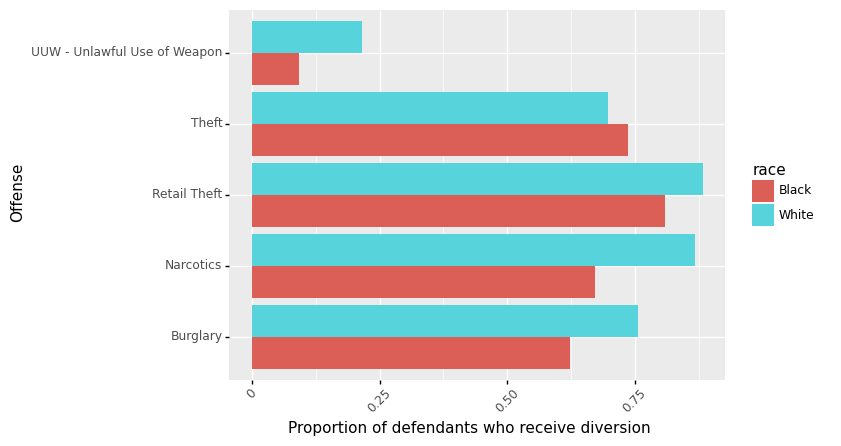

<ggplot: (8776457832355)>

In [18]:
(ggplot(divert_compare_t5, aes(x = 'updated_offense_category', y = 'prop_divert',
                              group = 'race', fill = 'race')) +
geom_bar(stat = "identity", position = "dodge") +
ylab("Proportion of defendants who receive diversion")+
xlab("Offense") +
theme(axis_text_x = element_text(angle = 45)) +
coord_flip())

# 2.3 Activity break 1: are elderly defendants more likely to receive diversion?

- Create a new column -- `is_elderly` when pulling from the caseinit table that takes on the value of 1 if the defendant's `AGE_AT_INCIDENT` is > 65; 0 otherwise
- Use `where` to row filter to initiations where the defendant is elderly and use group by to find the count of cases diverted and not diverted (`is_in_diversion`); pull the table with those counts
- Find the proportion of cases diverted for elderly versus non-elderly defendants (mean `is_in_diversion`} by group

In [19]:
## column creating
e_indicator = """
select *,
CASE 
    WHEN AGE_AT_INCIDENT > 65 THEN 1
    ELSE 0
END as is_elderly
from caseinit
"""

In [20]:
d1  = pd.read_sql_query(e_indicator, cnx)
d1.is_elderly.value_counts()

0    61413
1      643
Name: is_elderly, dtype: int64

In [21]:
## row filtering 
e_counts = """
select count(*) as count_group,
is_in_diversion
from caseinit
where AGE_AT_INCIDENT > 65
group by is_in_diversion
"""

In [22]:
d2  = pd.read_sql_query(e_counts, cnx)
d2

## seems like most diverted

,count_group,is_in_diversion
0,214,False
1,429,True


In [23]:
## combining; subquery to create new var and then grouping by that

prop_divert_byage = """
select 
avg(cast(is_in_diversion as INTEGER)) as prop_divert,
is_elderly
from caseinit
inner join (
    select CASE_PARTICIPANT_ID as tmp_id,
CASE 
    WHEN AGE_AT_INCIDENT > 65 THEN 1
    ELSE 0
END as is_elderly
from caseinit
    ) as tmp on tmp.tmp_id = caseinit.CASE_PARTICIPANT_ID
group by is_elderly
"""

In [24]:
d3  = pd.read_sql_query(prop_divert_byage, cnx)
d3

,prop_divert,is_elderly
0,0.678147,0
1,0.844156,1


# 3. Subqueries and aggregations: two datasets

Here, we're going to add in an additional table `divert` that, for the initiated cases that are sent to diversion, what types of non-prison diversion programs people are sent to

## 3.1 Looking at structure of `divert` table

In [25]:
## define a query to pull first 5 rows
## from caseinit table
sample_div_q = """
select * 
from divert 
limit 5
"""

divert_res = pd.read_sql_query(sample_div_q, cnx)
divert_res.head()
sorted(divert_res.columns)

,case_id,case_participant_id,received_date,offense_category,diversion_program,referral_date,diversion_count,primary_charge_offense_title,statute,race,gender,diversion_result,diversion_closed_date,is_in_initiations
0,506061999169,347644693595,01/01/2011 12:00:00 AM,Retail Theft,DS,06/17/2013 12:00:00 AM,2,RETAIL THEFT,720 ILCS 5/16A-3(a),Black,Male,Graduated,06/17/2013 12:00:00 AM,True
1,506061999169,347644693595,01/01/2011 12:00:00 AM,Retail Theft,VC,08/11/2011 12:00:00 AM,1,RETAIL THEFT,720 ILCS 5/16A-3(a),Black,Male,None,None,True
2,506066271711,347649309720,01/02/2011 12:00:00 AM,Retail Theft,MHC,09/14/2012 12:00:00 AM,1,RETAIL THEFT,720 ILCS 5/16A-3(a),Black,Male,Failed,09/14/2012 12:00:00 AM,True
3,506071709491,347654941393,01/03/2011 12:00:00 AM,Narcotics,MHC,07/27/2018 12:00:00 AM,1,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,720 ILCS 570/401(d)(i),Black,Female,None,None,True
4,506071709491,347654987555,01/03/2011 12:00:00 AM,Narcotics,MHC,07/27/2018 12:00:00 AM,1,POSSESSION OF A CONTROLLED SUBSTANCE,720 ILCS 570/402(c),White,Male,None,None,True


['case_id',
 'case_participant_id',
 'diversion_closed_date',
 'diversion_count',
 'diversion_program',
 'diversion_result',
 'gender',
 'is_in_initiations',
 'offense_category',
 'primary_charge_offense_title',
 'race',
 'received_date',
 'referral_date',
 'statute']

## 3.2 Left joining certain cols from caseinit onto diversions

### Left join with everything from divert; certain cols from caseinit

*Task*: join `caseinit` and `divert` on CASE_ID and CASE_PARTICIPANT_ID; select all columns from divert; `AGE_AT_INCIDENT` from `caseinit`

In [26]:
lj_q = """
select divert.*,
AGE_AT_INCIDENT
from divert
LEFT JOIN caseinit
ON divert.CASE_ID = caseinit.CASE_ID
AND divert.CASE_PARTICIPANT_ID = caseinit.CASE_PARTICIPANT_ID
"""

In [27]:
lj_d = pd.read_sql_query(lj_q, cnx)
lj_d.head()
lj_d.shape
lj_d.columns

,case_id,case_participant_id,received_date,offense_category,diversion_program,referral_date,diversion_count,primary_charge_offense_title,statute,race,gender,diversion_result,diversion_closed_date,is_in_initiations,age_at_incident
0,563654115781,412641908194,08/04/2017 12:00:00 AM,Forgery,BR9,01/10/2018 12:00:00 AM,1,FORGERY,720 ILCS 5/17-3(a)(2),White,Male,Graduated,09/05/2018 12:00:00 AM,True,54
1,547045774482,392955749192,06/13/2015 12:00:00 AM,Retail Theft,BR9,07/09/2015 12:00:00 AM,1,RETAIL THEFT,720 ILCS 5/16-25(a)(1),Other,Female,Graduated,04/27/2016 12:00:00 AM,True,40
2,567466970992,417158371404,02/10/2018 12:00:00 AM,Theft,BR9,03/21/2018 12:00:00 AM,1,THEFT,720 ILCS 5/16-1(a)(1)(A),Latinx,Male,Failed,12/12/2018 12:00:00 AM,True,42
3,556323404957,403872147080,08/06/2016 12:00:00 AM,Aggravated DUI,VC,09/25/2017 12:00:00 AM,1,AGGRAVATED DRIVING UNDER THE INFLUENCE OF ALCOHOL,625 ILCS 5/11-501(a),Black,Male,Failed,07/08/2019 12:00:00 AM,True,26
4,575119093489,425872646691,02/01/2019 12:00:00 AM,Possession of Stolen Motor Vehicle,BR9,09/23/2020 12:00:00 AM,1,POSSESSION OF A STOLEN MOTOR VEHICLE,625 ILCS 5/4-103(a)(1),White,Male,Graduated,09/23/2020 12:00:00 AM,True,19


(32982, 15)

Index(['case_id', 'case_participant_id', 'received_date', 'offense_category',
       'diversion_program', 'referral_date', 'diversion_count',
       'primary_charge_offense_title', 'statute', 'race', 'gender',
       'diversion_result', 'diversion_closed_date', 'is_in_initiations',
       'age_at_incident'],
      dtype='object')

### Deliberate error- selecting RACE col from both

In [28]:
lj_dup_q = """
select divert.*,
RACE
from divert
LEFT JOIN caseinit
ON divert.CASE_ID = caseinit.CASE_ID
AND divert.CASE_PARTICIPANT_ID = caseinit.CASE_PARTICIPANT_ID
"""

In [29]:
#lj_d_dup = pd.read_sql_query(lj_dup_q, cnx)


### Fixing that error - aliasing (temporary rename) race column

In [30]:
lj_dupfix_q = """
select divert.*,
AGE_AT_INCIDENT,
caseinit.RACE as caseinit_race
from divert
LEFT JOIN caseinit
ON divert.CASE_ID = caseinit.CASE_ID
AND divert.CASE_PARTICIPANT_ID = caseinit.CASE_PARTICIPANT_ID
"""

In [31]:
lj_d_dupfix = pd.read_sql_query(lj_dupfix_q, cnx)

In [32]:
## only diff is that in diversion dataset
## they have the category Latinx
## while in case initiations that's Hispanic or 
## White hispanic/latino
pd.crosstab(lj_d_dupfix.race, lj_d_dupfix.caseinit_race)

caseinit_race,American Indian,Asian,Biracial,Black,HISPANIC,Unknown,White,White [Hispanic or Latino],White/Black [Hispanic or Latino]
race,,,,,,,,,
Asian,0,492,0,0,0,0,0,0,0
Biracial,0,0,9,0,0,0,0,0,139
Black,0,0,0,18363,0,0,0,0,0
Latinx,0,0,0,0,458,0,0,4378,0
Other,7,0,0,0,0,0,0,0,0
Unknown,0,0,0,0,0,97,0,0,0
White,0,0,0,0,0,0,9039,0,0


### Another way to simplify: aliasing the tables in the join

*Task*: alias the `caseinit` table as `c` and the `divert` table as `d` and perform the same join/select as above

In [33]:
lj_alias_q = """
select d.*,
AGE_AT_INCIDENT, 
c.RACE as caseinit_race
from divert as d
LEFT JOIN caseinit as c
ON d.CASE_ID = c.CASE_ID
AND d.CASE_PARTICIPANT_ID = c.CASE_PARTICIPANT_ID
"""

In [34]:
lj_alias_d = pd.read_sql_query(lj_alias_q, cnx)

# 4. Combining agg and join

*Task*: among the cases that are diverted, for each of the charges (`UPDATED_OFFENSE_CATEGORY`) in the case initiations, find the percentage of defendants with that charge going to each `DIVERSION_PROGRAM`

## 4.1 Step one: count of offenses by diversion program

In [35]:
offenses_byprogram = """
select count(*) as count_offenses_byprogram,
UPDATED_OFFENSE_CATEGORY, DIVERSION_PROGRAM
from divert 
INNER JOIN caseinit 
ON divert.CASE_ID = caseinit.CASE_ID
AND divert.CASE_PARTICIPANT_ID = caseinit.CASE_PARTICIPANT_ID
group by UPDATED_OFFENSE_CATEGORY, DIVERSION_PROGRAM
order by count_offenses_byprogram desc
"""

In [36]:
cp = pd.read_sql_query(offenses_byprogram, cnx)
cp.head()

cp[cp.updated_offense_category == "Narcotics"]

,count_offenses_byprogram,updated_offense_category,diversion_program
0,5881,Narcotics,DDPP
1,5819,Narcotics,DS
2,2663,Narcotics,DC
3,1406,Narcotics,BR9
4,1348,Retail Theft,BR9


,count_offenses_byprogram,updated_offense_category,diversion_program
0,5881,Narcotics,DDPP
1,5819,Narcotics,DS
2,2663,Narcotics,DC
3,1406,Narcotics,BR9
6,1049,Narcotics,ARI
9,691,Narcotics,MHC
11,605,Narcotics,ACT
17,363,Narcotics,VC
27,196,Narcotics,SEED
29,168,Narcotics,RJCC


## 4.2 step two: count of offenses total

In [37]:
offenses_total = """
select count(*) as count_offenses_total,
UPDATED_OFFENSE_CATEGORY
from divert as d
INNER JOIN caseinit as c
ON d.CASE_ID = c.CASE_ID
AND d.CASE_PARTICIPANT_ID = c.CASE_PARTICIPANT_ID
group by UPDATED_OFFENSE_CATEGORY
order by count_offenses_total desc
"""

In [38]:
c = pd.read_sql_query(offenses_total, cnx)
c.head()

## check that total matches sum from first query- see both are 18841 
cp.count_offenses_byprogram[cp.updated_offense_category == "Narcotics"].sum()

,count_offenses_total,updated_offense_category
0,18841,Narcotics
1,3599,Retail Theft
2,1866,Theft
3,1432,Burglary
4,1116,Identity Theft


18841

## 4.3 Step three: combining into one query 



In [39]:
## mega query
offenses_prop = """
select 
count(*) as count_offenses,
count_offenses_byprogram,
DIVERSION_PROGRAM,
caseinit.UPDATED_OFFENSE_CATEGORY
from caseinit
inner join (select count(*) as count_offenses_byprogram,
UPDATED_OFFENSE_CATEGORY, DIVERSION_PROGRAM
from divert 
INNER JOIN caseinit 
ON divert.CASE_ID = caseinit.CASE_ID
AND divert.CASE_PARTICIPANT_ID = caseinit.CASE_PARTICIPANT_ID
group by UPDATED_OFFENSE_CATEGORY, DIVERSION_PROGRAM) as num
on num.UPDATED_OFFENSE_CATEGORY = caseinit.UPDATED_OFFENSE_CATEGORY
inner join (select CASE_ID as cid,
CASE_PARTICIPANT_ID as cpid
from divert
) as ppl_divert
on caseinit.CASE_ID = ppl_divert.cid
and caseinit.CASE_PARTICIPANT_ID = ppl_divert.cpid
group by caseinit.UPDATED_OFFENSE_CATEGORY, DIVERSION_PROGRAM,
count_offenses_byprogram
"""

In [40]:
cd_prop = pd.read_sql_query(offenses_prop, cnx)
cd_prop.head()

cd_prop['prop_o'] = cd_prop.count_offenses_byprogram/cd_prop.count_offenses

cd_prop[cd_prop.updated_offense_category == "Narcotics"].sort_values(by = 'prop_o',
                                                                    ascending = False)

,count_offenses,count_offenses_byprogram,diversion_program,updated_offense_category
0,55,8,BR9,Aggravated Assault Police Officer
1,55,30,MHC,Aggravated Assault Police Officer
2,55,17,VC,Aggravated Assault Police Officer
3,163,2,ACT,Aggravated Battery
4,163,6,BR9,Aggravated Battery


,count_offenses,count_offenses_byprogram,diversion_program,updated_offense_category,prop_o
151,18841,5881,DDPP,Narcotics,0.312138
152,18841,5819,DS,Narcotics,0.308848
150,18841,2663,DC,Narcotics,0.141341
149,18841,1406,BR9,Narcotics,0.074624
148,18841,1049,ARI,Narcotics,0.055676
153,18841,691,MHC,Narcotics,0.036675
147,18841,605,ACT,Narcotics,0.032111
156,18841,363,VC,Narcotics,0.019266
155,18841,196,SEED,Narcotics,0.010403
154,18841,168,RJCC,Narcotics,0.008917


# 4.4 Activity break 2 

- Create a new column using the `divert` table:  `is_vetcourt` where for values of `DIVERSION_PROGRAM` = 'VC', takes on value of 1, 0 otherwise; execute this query to make sure the query for this step is correct
-  In the case initiations table, filter to (1) defendants with `UPDATED_OFFENSE_CATEGORY` is 'Narcotics'; (2) race is Black or White; and (3) is diverted; execute this query to make sure the query for this step is correct
- Combine the queries from step 1 and 2 to find, among the defendants diverted to something for narcotics offenses, the percentage of Black and percentage of white defendants sent specifically to veteran's treatment court

In [41]:
q1 = """
select CASE WHEN DIVERSION_PROGRAM = 'VC'
THEN 1 ELSE 0 END as is_vetcourt,
DIVERSION_PROGRAM
from divert
"""

In [42]:
d1  = pd.read_sql_query(q1, cnx)
pd.crosstab(d1.is_vetcourt, d1.diversion_program)

diversion_program,ACT,ARI,BR9,DC,DDPP,DS,MHC,RJCC,SEED,VC
is_vetcourt,,,,,,,,,,
0,662,876,5148,3449,5599,5583,2134,336,153,0
1,0,0,0,0,0,0,0,0,0,730


In [43]:
q2 = """
select *
from caseinit
where RACE in ('Black', 'White')
and UPDATED_OFFENSE_CATEGORY = 'Narcotics' 
and is_in_diversion = 'True'
"""

In [44]:
d2  = pd.read_sql_query(q2, cnx)
d2.sample(n = 10)

,case_id,case_participant_id,offense_category,updated_offense_category,race,gender,age_at_incident,is_in_diversion
1905,552599107887,399435589000,Narcotics,Narcotics,Black,Male,20,True
1563,591933099417,446224774097,Narcotics,Narcotics,Black,Male,50,True
10942,586849357206,439961799859,Narcotics,Narcotics,Black,Male,59,True
12378,552923238450,399834237586,Narcotics,Narcotics,Black,Male,21,True
10435,551579912444,398215870197,Narcotics,Narcotics,Black,Male,58,True
10811,512518392561,354598609477,Narcotics,Narcotics,Black,Male,50,True
4243,580572798986,432138990701,Narcotics,Narcotics,Black,Male,36,True
7251,515893894848,358108480392,Narcotics,Narcotics,White,Male,23,True
11060,580477055206,432024833921,Narcotics,Narcotics,Black,Male,53,True
5707,546681248978,392524233794,Narcotics,Narcotics,White,Male,18,True


In [45]:
## putting them together
q3 = """
select 
avg(is_vetcourt) as prop_vc,
RACE
from caseinit
inner join (select CASE WHEN DIVERSION_PROGRAM = 'VC'
THEN 1 ELSE 0 END as is_vetcourt,
CASE_PARTICIPANT_ID as tmp_id
from divert) as tmp
on tmp.tmp_id = caseinit.CASE_PARTICIPANT_ID
where RACE in ('Black', 'White')
and UPDATED_OFFENSE_CATEGORY = 'Narcotics' 
group by RACE 
"""

In [46]:
d3  = pd.read_sql_query(q3, cnx)
d3

,prop_vc,race
0,0.016346,White
1,0.024228,Black
